## Case 1 - ADA

### Tractament de les dades

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
training = pd.read_csv('training_set.csv')
training.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
training.dtypes

object_id      int64
mjd          float64
passband       int64
flux         float64
flux_err     float64
detected       int64
dtype: object

In [4]:
print(training.isnull().sum())

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64


array([[<AxesSubplot:title={'center':'object_id'}>,
        <AxesSubplot:title={'center':'mjd'}>],
       [<AxesSubplot:title={'center':'passband'}>,
        <AxesSubplot:title={'center':'flux'}>],
       [<AxesSubplot:title={'center':'flux_err'}>,
        <AxesSubplot:title={'center':'detected'}>]], dtype=object)

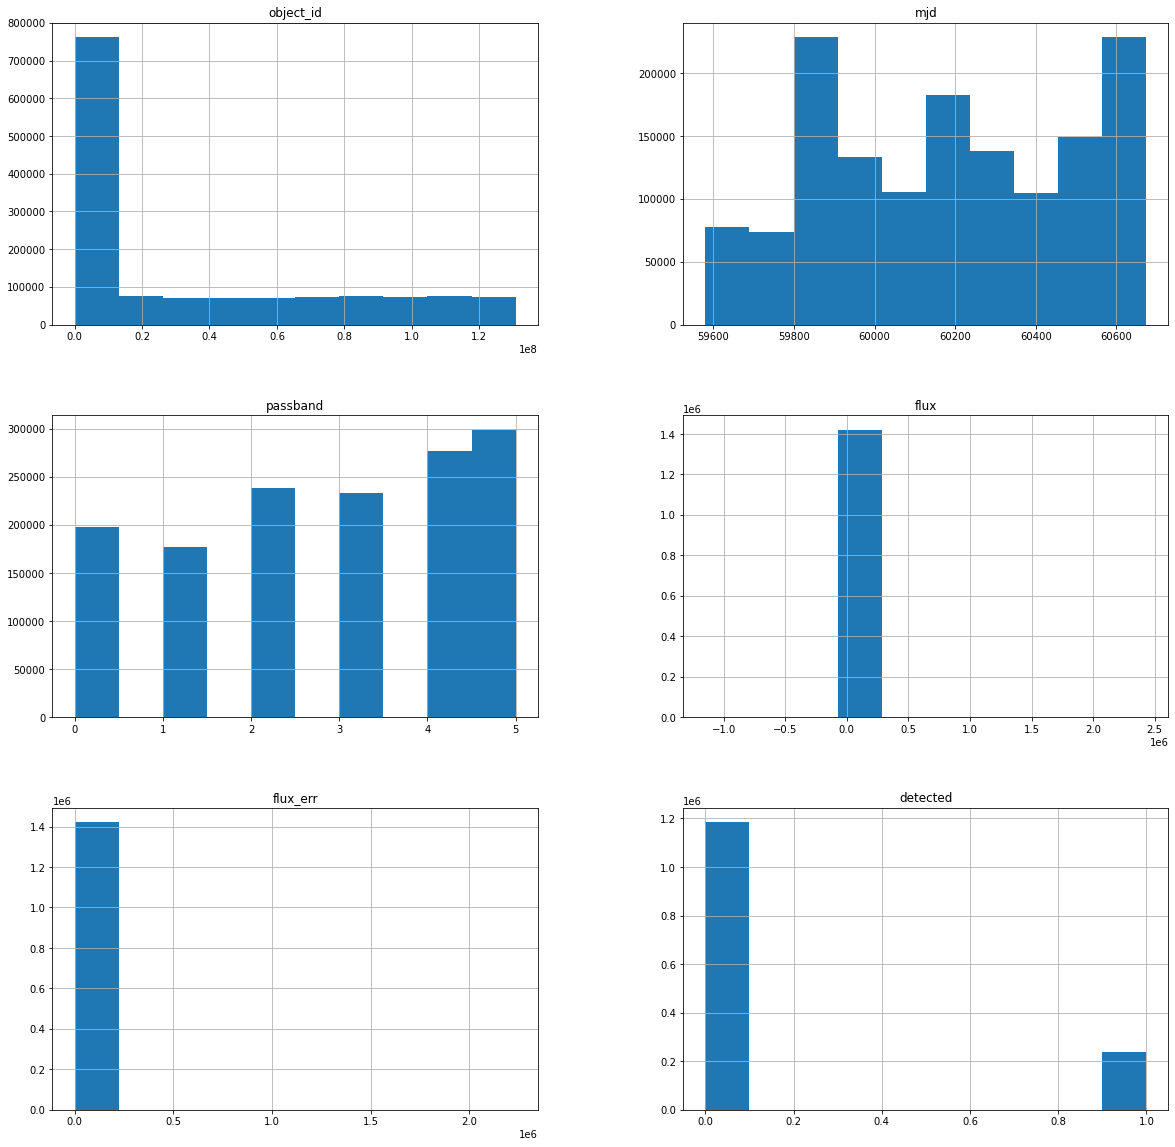

In [5]:
training.hist(figsize=(20,20))


No tenim les dades de classe així que necessitarem les dades de metadata per tal de completar la nostra informació.

In [6]:
metadata=pd.read_csv('training_set_metadata.csv')
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [7]:
merged = training.merge(metadata, on = "object_id")
merged.head()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


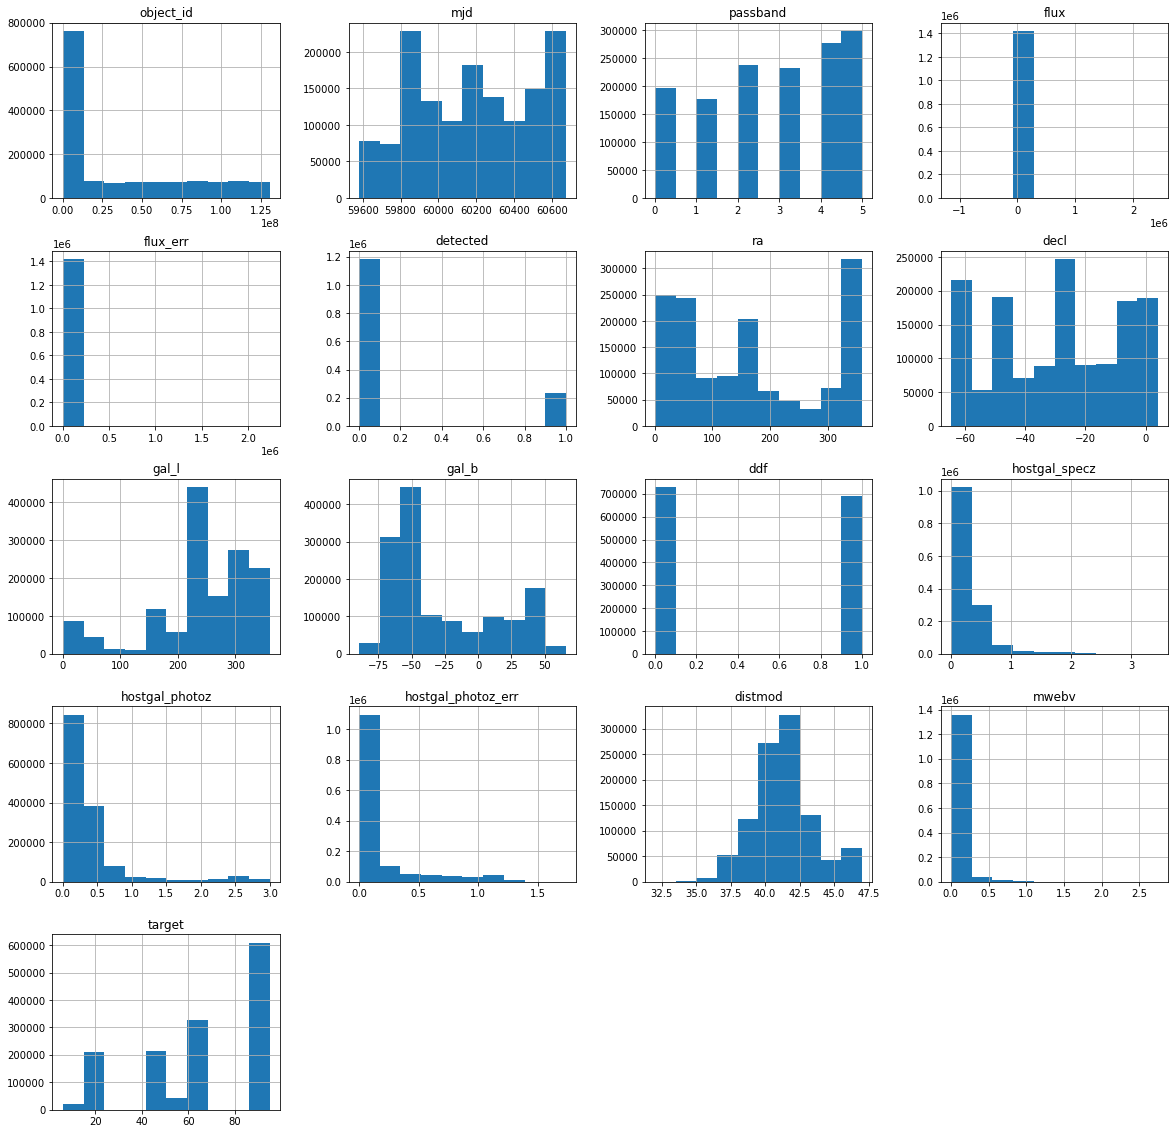

In [8]:
hist=merged.hist(figsize=(20,20))

Podem veure clarament que les dades no estan balancejades, mirant l'histograma de target. Anem a veure exactament quantes mostres tenim de cada classe.

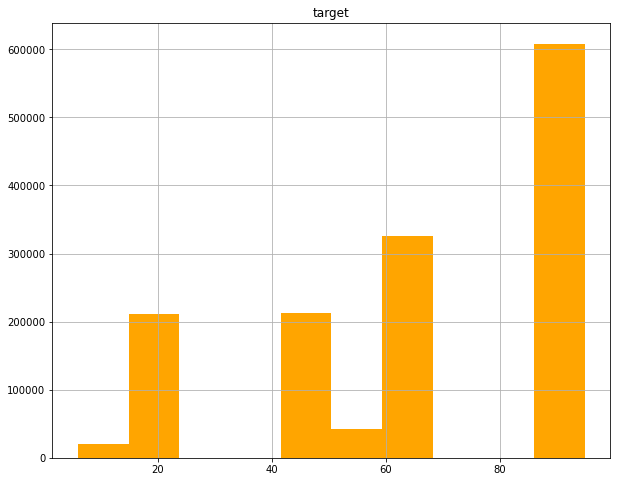

In [9]:
hist_targ=merged.hist(column=["target"], figsize=(10, 8), color='orange')

In [10]:
merged.dtypes

object_id               int64
mjd                   float64
passband                int64
flux                  float64
flux_err              float64
detected                int64
ra                    float64
decl                  float64
gal_l                 float64
gal_b                 float64
ddf                     int64
hostgal_specz         float64
hostgal_photoz        float64
hostgal_photoz_err    float64
distmod               float64
mwebv                 float64
target                  int64
dtype: object

In [11]:
merged['target'].value_counts()

90    465046
42    212447
65    185894
16    147474
62     87079
88     70622
15     64440
92     41985
67     39887
52     37480
95     30712
6      20830
64     13418
53      4391
Name: target, dtype: int64

In [12]:
merged.isnull().sum()[merged.isnull().sum() > 0]

distmod    400574
dtype: int64

In [13]:
values=merged.isnull().sum()[merged.isnull().sum() > 0]
total=len(merged['object_id'])
values/total

distmod    0.281756
dtype: float64

Té molts valors que són nulls l'atribut distmod. Un 30% de les seves dades son null.

Podem mirar les correlacions i veiem que alguns atributs tenen correlacions amb el nostre atribut objectiu bastant altes.

In [14]:
columns=merged.columns
correlations_targ = merged.corr()['target'].abs().sort_values(ascending=False)
correlations_targ

target                1.000000
hostgal_specz         0.411228
distmod               0.280212
hostgal_photoz        0.248357
ddf                   0.214500
mwebv                 0.182167
object_id             0.165711
gal_b                 0.139884
hostgal_photoz_err    0.124872
gal_l                 0.048147
passband              0.045684
decl                  0.043083
detected              0.022771
mjd                   0.015243
ra                    0.006092
flux                  0.004772
flux_err              0.000935
Name: target, dtype: float64

<AxesSubplot:>

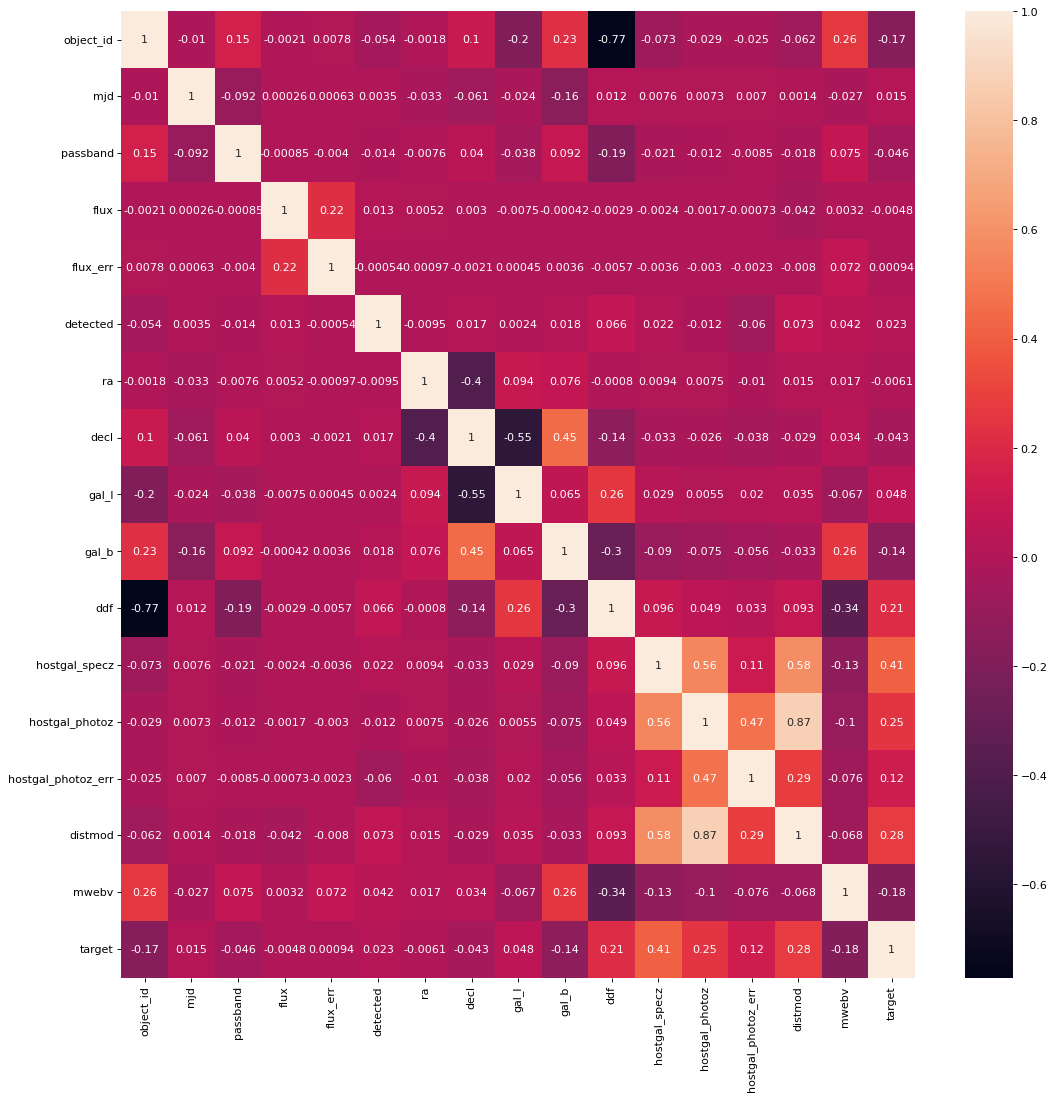

In [15]:
plt.figure(figsize=(16, 16), dpi=80)
sns.heatmap(merged.corr(), annot=True)

Mirem si les dades estan normalitzades.

In [16]:
for col in merged.select_dtypes(exclude='object'):
    _, pvalue = scipy.stats.normaltest(merged[col])
    if pvalue < 1e-3:
        print(col)

object_id
mjd
passband
flux
flux_err
detected
ra
decl
gal_l
gal_b
ddf
hostgal_specz
hostgal_photoz
hostgal_photoz_err
mwebv
target


Les dades no estan normalitzades.

In [20]:
test = pd.read_csv('test_set_batch1.csv')
test.head()

,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.3205,2,-1.299735,1.357315,0
1,13,59798.3281,1,-2.095392,1.148654,0
2,13,59798.3357,3,-0.923794,1.763655,0
3,13,59798.3466,4,-4.009815,2.602911,0
4,13,59798.3576,5,-3.403503,5.367328,0


In [27]:
merged=merged.drop(columns='distmod', axis=1)

In [31]:
y=merged['target']
x=merged.drop(columns='target', axis=1)

classificators= {
    'KNeighbors': KNeighborsClassifier(n_neighbors=15),
    'RandomForest': RandomForestClassifier(n_estimators=10)
}
clf=classificators['RandomForest']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot()
#plt.title(f'Matriu de confusió amb el classificador {name}')
#plt.show()


In [32]:
score

0.9972392303607288

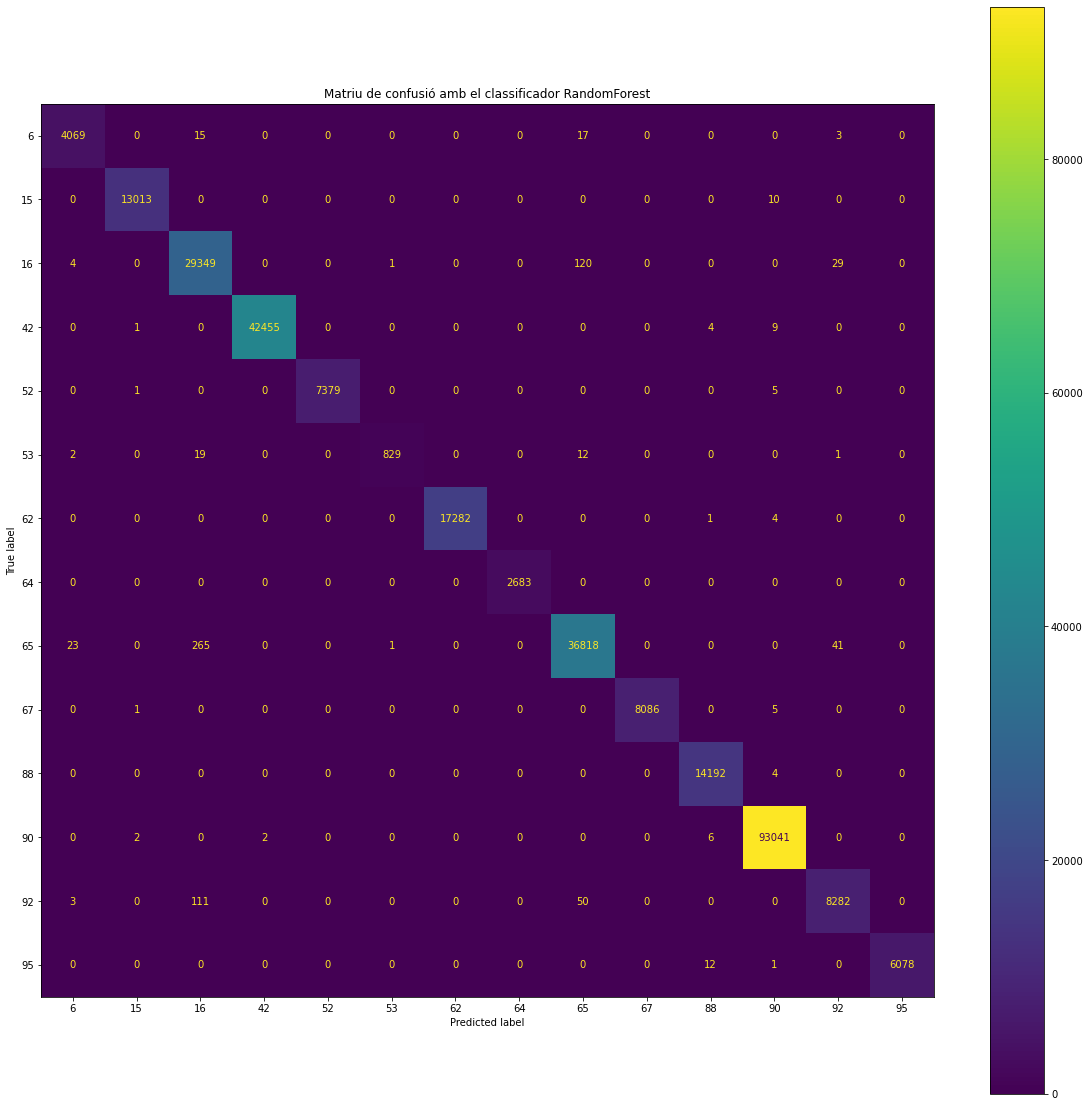

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)

plt.title(f'Matriu de confusió amb el classificador RandomForest')
plt.show()